In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head(3)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965


In [4]:
test.head(3)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794


**Задание 1:** Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы

In [5]:
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))
train.describe()

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [7]:
train.isnull().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

In [8]:
numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 201


Index(['target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

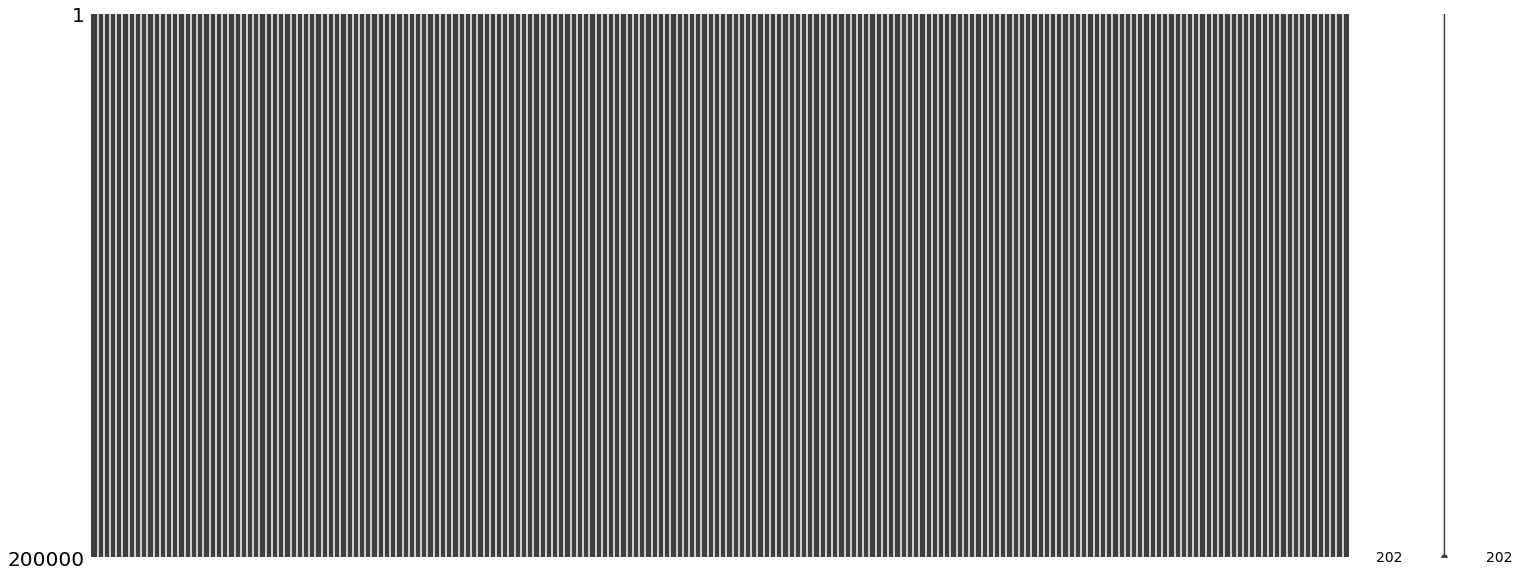

In [9]:
msno.matrix(train)

In [10]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 and feature not in ["target"]
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 0


In [11]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature + ["target"]
]
print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 200


В датафрейме 200тыс наблюдений, 201 признак и целевая переменная. Все признаки, кроме, ID_code - числовые (непрерывные). Пропусков нет.

**Задание 2:** Сделать базовый анализ целевой переменной, сделать выводы;

In [12]:
target = train['target']
target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [13]:
target.value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

Доля позитивного класса составляет 10% (20098 наблюдений). Наблюдается дисбалланс классов, но работать с такими данными можно.

**Задание 3:** Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

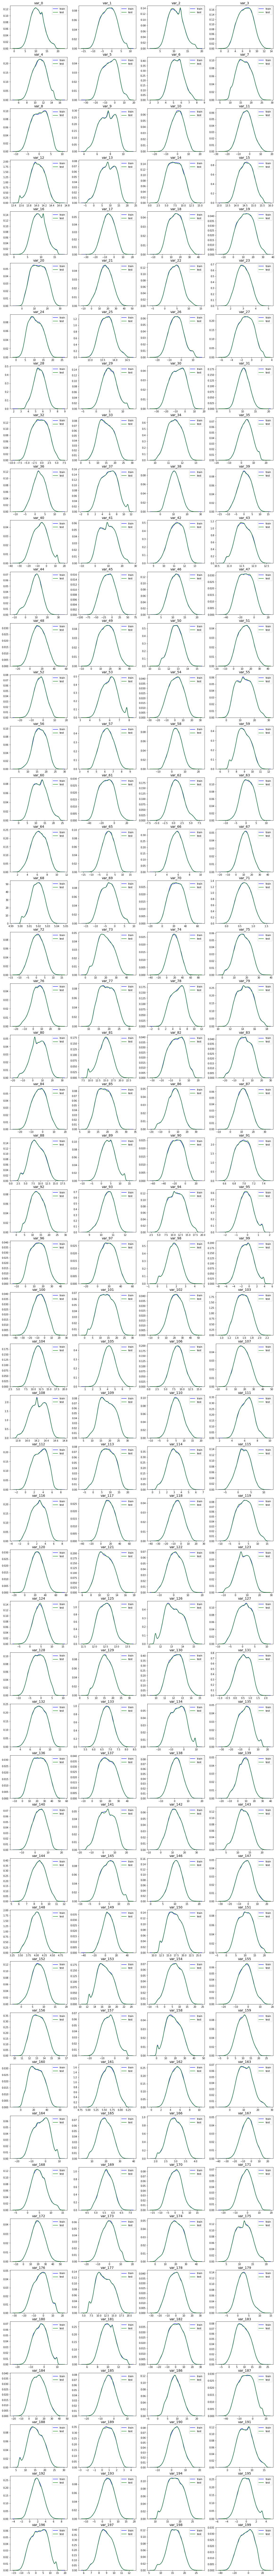

In [14]:
fig, axes = plt.subplots(50, 4, figsize=(20, 200))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)

In [15]:
target = train['target']

fig, axes = plt.subplots(50, 4, figsize=(50, 550))

for num, feature in enumerate(continuous_feature):
    data = train[feature].copy()
    sns.boxplot(y=feature, x=target, data=train, palette="viridis", ax=axes[num//4, num%4]) 
    axes[num//4, num%4].tick_params(axis="x", rotation=90)

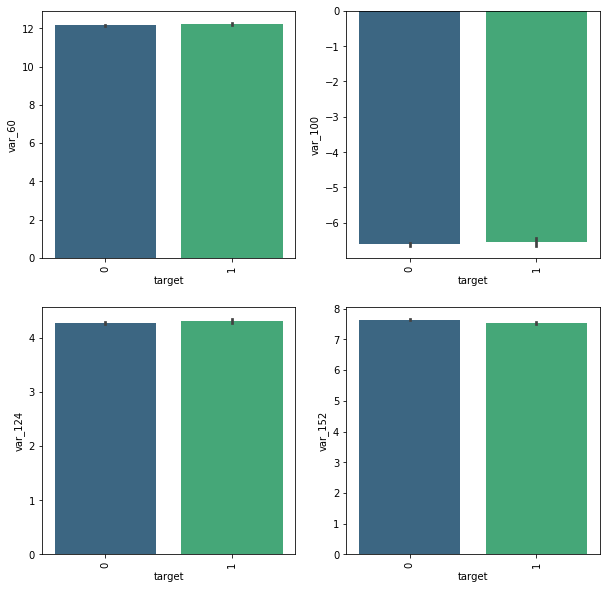

In [16]:
some_features = ['var_60', 'var_100', 'var_124', 'var_152']
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for num, feature in enumerate(some_features):
    data = train[feature].copy()
    sns.barplot(y=feature, x=target, data=train, palette="viridis", ax=axes[num//2, num%2]) 
    axes[num//2, num%2].tick_params(axis="x", rotation=90)

Распределения на выборке для обучения и для тестирования совпадают. В некоторых переменных (например, var_11, var_20, var_38, var_52 и т.п.) наблюдаются выбросы. Визуально распределение переменных близко к нормальному, но эта гипотеза требует дальнейшего исследования. Для некоторых признаков, таких как, например, var_60, var_100, var_124, var_152, визуально кажется, что доли в разрезе целевой переменной похожи. Эта гипотеза требует более тщательного изучения графиков, а также, возможно, детельного рассмотрения конкретных признаков.

**Задание 4:** Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

In [17]:
target1 = train.loc[train['target']==1, :].describe()
target0 = train.loc[train['target']==0, :].describe()

In [18]:
target1

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,20098.0,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,...,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000,20098.000000
mean,1.0,11.156418,-1.017613,11.156633,6.864113,11.131337,-4.336522,5.581966,16.514917,0.479432,...,3.998064,7.864560,1.738266,3.120260,17.779568,-0.021130,2.688583,8.810815,15.393283,-2.532243
std,0.0,3.270293,4.220638,2.841075,2.070898,1.649266,8.140281,0.922442,3.421365,3.340028,...,4.814830,3.210779,1.482537,4.067550,3.193153,1.485975,5.556892,0.952554,3.248123,10.435910
min,1.0,0.452800,-14.037000,2.946200,0.374000,5.876200,-28.246100,2.496000,7.302400,-9.839100,...,-11.906900,-2.343000,-3.317700,-11.783400,10.120700,-5.018500,-14.020400,6.119000,6.558700,-38.852800
25%,1.0,8.695875,-4.203475,8.961125,5.314300,9.911250,-10.615800,4.882250,13.880125,-2.107425,...,0.466025,5.418550,0.669775,0.343000,15.420025,-1.103950,-1.572225,8.155250,13.232500,-10.285050
50%,1.0,11.001350,-0.992650,11.096700,6.900200,11.156300,-4.101950,5.601800,16.412700,0.579600,...,4.017500,7.846550,1.667500,3.176700,17.730500,-0.057350,2.831050,8.795400,15.427950,-1.971850
75%,1.0,13.343700,2.001375,13.047025,8.384725,12.328450,1.619950,6.218550,19.044250,3.127825,...,7.407925,10.018400,2.749050,6.063825,20.201800,0.986450,6.956250,9.517000,17.776425,5.701475
max,1.0,19.458300,9.029800,18.294100,12.706900,15.692500,16.423600,8.285200,27.039800,9.033000,...,16.746100,16.520500,7.647600,17.150400,27.295300,4.088100,17.161400,11.706900,25.857100,24.564600


In [19]:
target0

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,179902.0,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,...,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000,179902.000000
mean,0.0,10.626681,-1.695770,10.665876,6.788979,11.072412,-5.146736,5.389620,16.549306,0.262347,...,3.149130,7.390800,1.949017,3.355403,18.017716,-0.155601,2.260297,8.919032,15.924058,-3.415273
std,0.0,3.008564,4.024813,2.612961,2.040082,1.620103,7.827522,0.857983,3.417700,3.331105,...,4.522568,2.997847,1.476456,3.982819,3.127715,1.422275,5.441118,0.917467,2.978539,10.434525
min,0.0,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-10.845500,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.0,8.429500,-4.790775,8.698025,5.247625,9.880600,-11.260950,4.756425,13.950125,-2.342575,...,-0.111850,5.130825,0.915300,0.612400,15.656700,-1.178700,-1.987375,8.262100,13.896000,-11.312025
50%,0.0,10.478600,-1.682600,10.529000,6.817000,11.104400,-4.917700,5.364400,16.460850,0.371400,...,3.117250,7.297000,1.928950,3.417550,17.982400,-0.184200,2.359700,8.897700,15.988500,-2.914000
75%,0.0,12.693075,1.287700,12.463900,8.317875,12.253100,0.844600,5.981300,19.108800,2.919300,...,6.296375,9.461300,2.969800,6.217075,20.417500,0.813000,6.513425,9.601500,18.095400,4.741400
max,0.0,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [20]:
df_stat = pd.DataFrame(data = {'mean_0': target0.loc['mean'],
                               'mean_1': target1.loc['mean'],
                               'std_0': target0.loc['std'],
                               'std_1': target1.loc['std'],
                              })

In [25]:
df_stat

,mean_0,mean_1,std_0,std_1
target,0.000000,1.000000,0.000000,0.000000
var_0,10.626681,11.156418,3.008564,3.270293
var_1,-1.695770,-1.017613,4.024813,4.220638
var_2,10.665876,11.156633,2.612961,2.841075
var_3,6.788979,6.864113,2.040082,2.070898
...,...,...,...,...
var_195,-0.155601,-0.021130,1.422275,1.485975
var_196,2.260297,2.688583,5.441118,5.556892
var_197,8.919032,8.810815,0.917467,0.952554
var_198,15.924058,15.393283,2.978539,3.248123


In [26]:
df_stat_train_test = pd.DataFrame(data = {'mean_train': train.describe().loc['mean'],
                               'mean_test': test.describe().loc['mean'],
                               'std_train': train.describe().loc['std'],
                               'std_test': test.describe().loc['std'],
                              })

In [27]:
df_stat_train_test

,mean_train,mean_test,std_train,std_test
target,0.100490,NaN,0.300653,NaN
var_0,10.679914,10.658737,3.040051,3.036716
var_1,-1.627622,-1.624244,4.050044,4.040509
var_10,0.394340,0.371335,5.500793,5.508661
var_100,-6.600518,-6.674013,9.181683,9.181642
...,...,...,...,...
var_95,-0.084344,-0.088772,0.621125,0.617136
var_96,14.400433,14.425378,8.525400,8.552785
var_97,18.539645,18.603350,12.642382,12.674441
var_98,1.752012,1.751693,0.715836,0.713795


**Задание 5:** Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?